In [55]:
######## Avoid TypeCheck Warning #########
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())
############################################

import jax
# from jax.config import config
# config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import seaborn as sns

((100, 1), (100,))

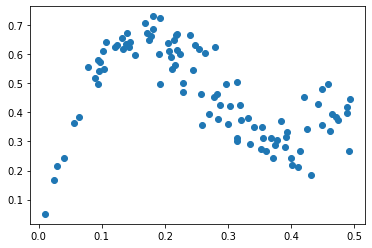

In [73]:
N = 100
# seed = jax.random.PRNGKey(0)
# X = jax.random.uniform(seed, (N,), minval=0, maxval=0.5)
# X_test = jnp.linspace(-0.5, 1, N*2).reshape(-1,1)
# # noise = jax.random.normal(jax.random.PRNGKey(123), (N,1))*0.2
# # y = X**3 - X**2 + noise
# # y = 3*X + 2 + noise
# # y = jnp.sin(2*X) + noise
# epsilons = jax.random.normal(seed, shape=(3,1)) * 0.02
# y = X + 0.3 * jnp.sin(2 * jnp.pi * (X + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (X + epsilons[1])) + epsilons[2]
# y = y.ravel()
# aux = {'X': X}


def load_dataset():
    # Generate dataset and grid
    key, subkey = jax.random.split(jax.random.PRNGKey(1))
    # X = jax.random.uniform(key, shape=(500, 1), minval=-2, maxval=2)
    # x_grid = jnp.linspace(-2, -2, 500).reshape(-1, 1)
    X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
#     X = jnp.linspace(0, 0.5, N).reshape(-1, 1)
    x_grid = jnp.linspace(0, 0.5, 100).reshape(-1, 1)
    # X = jax.random.uniform(key, shape=(100, 1), minval=-1.5, maxval=1.5)
    # x_grid = jnp.linspace(-2, -2, 100).reshape(-1, 1)
    # Define function
    def target_toy(key, x):
        epsilons = jax.random.normal(key, shape=(3,)) * 0.02
        return (
            x + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
        )
        # return (
        #     x**3 -x**2 + 3*epsilons[2]
        #     #x**3-x**2 + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
        # )
        # return (
        #     jnp.sin(2 * (x)) + 0.2*epsilons[2]
        # )
    # Define vectorized version of function
    target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)
    # Generate target values
    keys = jax.random.split(subkey, X.shape[0])
    Y = target_vmap(keys, X)

#     noise = jax.random.normal(jax.random.PRNGKey(0), (N,1))*0.2
#     Y = jnp.sin(12*X) + noise
    idx = jnp.argsort(X.ravel())
    return X[idx],Y.ravel()[idx],x_grid

X, y, X_test = load_dataset()
plt.scatter(X, y);
X.shape, y.shape

In [74]:
import flax.linen as nn
from flax.core.frozen_dict import freeze, unfreeze
from jax.flatten_util import ravel_pytree

class MLP(nn.Module):
    layers: list
    
    @nn.compact
    def __call__(self, x):
        for num_features in self.layers[:-1]:
            x = nn.relu(nn.Dense(num_features, kernel_init=jax.nn.initializers.lecun_normal())(x))
        x = nn.Dense(self.layers[-1], kernel_init=jax.nn.initializers.lecun_normal())(x)
        return x.ravel()

mlp = MLP([16, 1])

In [92]:
params = mlp.init(jax.random.PRNGKey(8), X)
params_array, unravel_fn = ravel_pytree(unfreeze(params))
prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(len(params_array)), scale_diag=jnp.ones(len(params_array)))
approx_posterior = tfd.MultivariateNormalDiag(loc=params_array, scale_diag=-7*jnp.ones(len(params_array)))
# seed = jax.random.PRNGKey(1)
# chol_cov = tfd.CholeskyLKJ(dimension=len(params_array), concentration=10.0).sample(seed=seed)
# approx_posterior = tfd.MultivariateNormalTriL(loc=params_array, scale_tril=0.01*chol_cov)

def log_likelihood_fn(approx_posterior, seed):
    seeds = jax.random.split(seed, num=1)
    def log_likelihood_per_sample(seed):
        sample = approx_posterior.sample(seed=seed)
        params = freeze(unravel_fn(sample))
        mean_y = mlp.apply(params, X)
        std_y = jnp.ones_like(mean_y)*0.2
        return tfd.MultivariateNormalDiag(loc=mean_y, scale_diag=std_y).log_prob(y)
    return jax.vmap(log_likelihood_per_sample)(seeds).mean()

def loss_fn(approx_posterior, seed):
    post_params, treedef = jax.tree_flatten(approx_posterior)
    post_params[1] = jnp.exp(post_params[1])
    approx_posterior = jax.tree_unflatten(treedef, post_params)
    kld = tfd.kl_divergence(approx_posterior, prior)
    log_likelihood = log_likelihood_fn(approx_posterior, seed)
    return kld - log_likelihood

def loss_fn2(approx_posterior, seed):
    post_params, treedef = jax.tree_flatten(approx_posterior)
    post_params[1] = jnp.exp(post_params[1])
    approx_posterior = jax.tree_unflatten(treedef, post_params)
    
    seeds = jax.random.split(seed, num=50)
    def loss_per_sample(seed):
        sample = approx_posterior.sample(seed=seed)
        log_prior = prior.log_prob(sample)
        log_posterior = approx_posterior.log_prob(sample)
        params = freeze(unravel_fn(sample))
        mean_y = mlp.apply(params, X)
        std_y = jnp.ones_like(mean_y)
        log_likelihood = tfd.MultivariateNormalDiag(loc=mean_y, scale_diag=std_y).log_prob(y)
        return - log_likelihood - log_prior + log_posterior
    return jax.vmap(loss_per_sample)(seeds).mean()


value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn2))
tx = optax.adam(learning_rate=0.01)

state = tx.init(approx_posterior)

@jax.jit
def one_step(params, seed):
    approx_posterior, state = params
    loss, grads = value_and_grad_fn(approx_posterior, seed)
    updates, state = tx.update(grads, state)
    approx_posterior = optax.apply_updates(approx_posterior, updates)
    return (approx_posterior, state), loss

seed = jax.random.PRNGKey(123456)
seeds = jax.random.split(seed, num=2000)
(approx_posterior, state), losses = jax.lax.scan(one_step, (approx_posterior, state), seeds)

# losses = []
# for i in range(1000):
#     seed = jax.random.PRNGKey(i+123)
#     loss, grads = value_and_grad_fn(approx_posterior, seed)
#     losses.append(loss)
#     updates, state = tx.update(grads, state)
#     approx_posterior = optax.apply_updates(approx_posterior, updates)

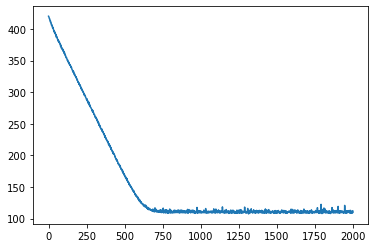

In [93]:
plt.plot(losses);
# losses

In [94]:
X_test = jnp.linspace(-0.5, 1, 200).reshape(-1,1)

# if isinstance(approx_posterior, tfd.MultivariateNormalDiag):
post_params, treedef = jax.tree_flatten(approx_posterior)
post_params[1] = jnp.exp(post_params[1])
posterior = jax.tree_unflatten(treedef, post_params)
# else:
#     posterior = approx_posterior

def predict_y(seed):
    weights = posterior.sample(seed=seed)
#     print(weights)
    weights = freeze(unravel_fn(weights))
#     print(weights)
    return mlp.apply(weights, X_test)

Np = 1000
seed = jax.random.PRNGKey(10)
seeds = jax.random.split(seed, Np)
samples = jax.vmap(predict_y)(seeds)

(-0.5, 0.75)

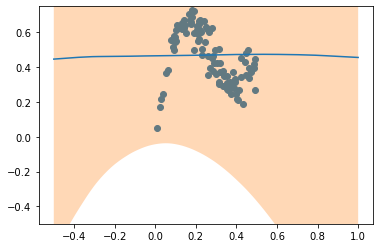

In [95]:
# %matplotlib notebook
sample_mean = samples.mean(axis=0)
sample_std = samples.std(axis=0)

lower =  sample_mean - 2*sample_std
upper =  sample_mean + 2*sample_std

plt.scatter(X, y)
plt.plot(X_test, sample_mean);
plt.fill_between(X_test.ravel(), lower-0.1, upper+0.1, alpha=0.3);
plt.ylim(-0.5,0.75)